Данные

https://www.kaggle.com/dalpozz/creditcardfraud/data

In [2]:
import requests
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
fn = 'creditcard.csv.zip'
fn_out_train = 'creditcard_vw_format_train'
fn_out_test = 'creditcard_vw_format_test'
fn_out_validation = 'creditcard_vw_format_validation'

fn_out_train_weight = 'creditcard_vw_format_train_weight'
fn_out_test_weight = 'creditcard_vw_format_test_weight'
fn_out_validation_weight = 'creditcard_vw_format_validation_weight'

In [4]:
df = pd.read_csv(fn, compression='zip', header=0, sep=',', quotechar='"')

In [5]:
df['Class'] = df['Class']* 2 - 1

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,-1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,-1
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,-1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,-1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,-1


In [10]:
df['Class'].value_counts()

-1    284315
 1       492
Name: Class, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [9]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,-0.996545
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.083054
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,-1.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,-1.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,-1.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,-1.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Time** - the seconds elapsed between each transaction and the first transaction in the dataset. Numeric  
**V1** - First principle component Numeric  
**V2** - Second principle component Numeric  
**V3** - Third principle component Numeric  
...  
**V28** - Twenty-eighth principle component Numeric  
**Amount** - Transaction Amount Numeric   
**Class** - The actual classification classes Numeric  

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

# Vowpal Wabbit

Туториалы
https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial

Туториал для сборки в unix
https://github.com/JohnLangford/vowpal_wabbit/wiki/v7.0_tutorial.pdf

## Используемый формат данных

Основным интерфейсом для работы с VW является shell

0 | price:.23 sqft:.25 age:.05

0 - значение целевой переменной
5 - вес
price:.23 ... - признаки

приведем данные к такому формату:

In [8]:
skip_columns = {"Class", 'Index'}

def df_to_file(file_name, data):
    with open(file_name, 'w') as f:
        for row in data.itertuples():
            features = row._asdict()
            features_formatted = ' '.join('{}:{}'.format(k, v) for k, v in features.iteritems() if k not in skip_columns)
            f.write('{} | {}\n'.format(row.Class, features_formatted))

In [9]:
train, test = train_test_split(df, test_size=0.2)
train, validation = train_test_split(train, test_size=0.2)

In [10]:
df_to_file(fn_out_train, train)
df_to_file(fn_out_validation, validation)

In [11]:
%%sh -s "$fn_out_train" "$fn_out_validation" "$fn_out_test"

wc -l $1
wc -l $2


182276 creditcard_vw_format_train
45569 creditcard_vw_format_validation


In [12]:
%%sh -s "$fn_out_train" "$fn_out_validation" "$fn_out_test"

vw -d $1 -f simple_model.vw 

final_regressor = simple_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = creditcard_vw_format_train
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000       31
1.000000 1.000000            2            2.0  -1.0000   0.0000       31
0.683059 0.366118            4            4.0  -1.0000  -0.6838       31
0.611262 0.539464            8            8.0  -1.0000  -0.2981       31
0.485825 0.360388           16           16.0  -1.0000  -0.1263       31
0.290409 0.094993           32           32.0  -1.0000  -1.0000       31
0.165169 0.039930           64           64.0  -1.0000  -1.0000       31
0.092495 0.019820          128          128.0  -1.0000  -1.0000       31
0.048166 0.003837          256          256.0  -1.0000  -1.0000       31
0.024196 0.000226

In [13]:
%%sh -s "$fn_out_train" "$fn_out_validation" "$fn_out_test"

vw -i simple_model.vw -t -d $2 -p simple_model_predictions.vw

only testing
predictions = simple_model_predictions.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = creditcard_vw_format_validation
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  -1.0000  -1.0000       31
0.000000 0.000000            2            2.0  -1.0000  -1.0000       31
0.000000 0.000000            4            4.0  -1.0000  -1.0000       31
0.000000 0.000000            8            8.0  -1.0000  -1.0000       31
0.000000 0.000000           16           16.0  -1.0000  -1.0000       31
0.000000 0.000000           32           32.0  -1.0000  -1.0000       31
0.000000 0.000000           64           64.0  -1.0000  -1.0000       31
0.000000 0.000000          128          128.0  -1.0000  -1.0000       31
0.031266 0.062531          256          256.0  -1.0000  -1.0000 

In [14]:
!head simple_model_predictions.vw

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1


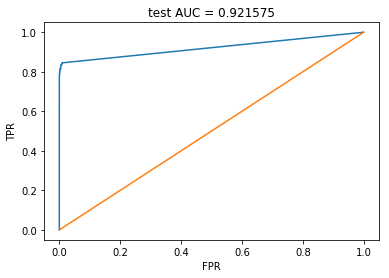

In [16]:
with open('simple_model_predictions.vw') as pred_file:
    validation_prediction = [float(label) for label in pred_file.readlines()]

auc = roc_auc_score(validation['Class'], validation_prediction)
curve = roc_curve(validation['Class'], validation_prediction)

plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

Добавим вес меньшему классу

In [27]:
skip_columns = {"Class", 'Index'}

def df_to_file_weight(file_name, data):
    with open(file_name, 'w') as f:
        for row in data.itertuples():
            features = row._asdict()
            weight = 1000 if row.Class == 1 else 1
            features_formatted = ' '.join('{}:{}'.format(k, v) for k, v in features.iteritems() if k not in skip_columns)
            f.write('{} {} | {}\n'.format(row.Class, weight, features_formatted))

In [28]:
df_to_file_weight(fn_out_train_weight, train)
df_to_file_weight(fn_out_validation_weight, validation)

In [29]:
%%sh -s "$fn_out_train_weight" "$fn_out_validation_weight" "$fn_out_test_weight"

vw -d $1 -f model_weights.vw 

final_regressor = model_weights.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = creditcard_vw_format_train_weight
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000       31
1.000000 1.000000            2            2.0  -1.0000   0.0000       31
0.683059 0.366118            4            4.0  -1.0000  -0.6838       31
0.611262 0.539464            8            8.0  -1.0000  -0.2981       31
0.485825 0.360388           16           16.0  -1.0000  -0.1263       31
0.290409 0.094993           32           32.0  -1.0000  -1.0000       31
0.165169 0.039930           64           64.0  -1.0000  -1.0000       31
0.092495 0.019820          128          128.0  -1.0000  -1.0000       31
0.048166 0.003837          256          256.0  -1.0000  -1.0000       31
0.024196 

In [30]:
%%sh -s "$fn_out_train_weight" "$fn_out_validation_weight" "$fn_out_test_weight"

vw -i model_weights.vw  -t -d $2 -p model_weights_predictions.vw

only testing
predictions = model_weights_predictions.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = creditcard_vw_format_validation_weight
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  -1.0000  -1.0000       31
0.000000 0.000000            2            2.0  -1.0000  -1.0000       31
0.000000 0.000000            4            4.0  -1.0000  -1.0000       31
0.000000 0.000000            8            8.0  -1.0000  -1.0000       31
0.004058 0.008117           16           16.0  -1.0000  -1.0000       31
0.002029 0.000000           32           32.0  -1.0000  -1.0000       31
0.012914 0.023799           64           64.0  -1.0000  -1.0000       31
0.010697 0.008480          128          128.0  -1.0000  -0.8728       31
3.233146 3.604410          240         1239.0   1.0000  

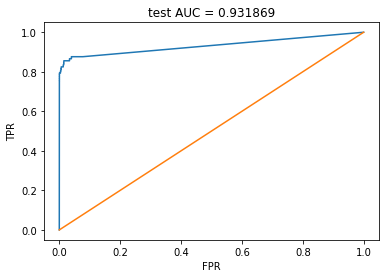

In [31]:
with open('model_weights_predictions.vw') as pred_file:
    validation_prediction = [float(label) for label in pred_file.readlines()]

auc = roc_auc_score(validation['Class'], validation_prediction)
curve = roc_curve(validation['Class'], validation_prediction)

plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);